implementation of the pizza with friend problem

In [55]:
from collections import Counter

class Multiset:
    """Multiset"""

    def __init__(self, init=None):
        self._data = Counter()
        if init:
            for item in init:
                self.add(item)

    def __contains__(self, item):
        return item in self._data and self._data[item] > 0

    def __getitem__(self, item):
        return self.count(item)

    def __iter__(self):
        return (i for i in sorted(self._data.keys()) for _ in range(self._data[i]))

    def __len__(self):
        return sum(self._data.values())

    def __copy__(self):
        t = Multiset()
        t._data = self._data.copy()
        return t

    def __str__(self):
        return f"M{{{', '.join(repr(i) for i in self)}}}"

    def __repr__(self):
        return str(self)

    def __or__(self, other: "Multiset"):
        tmp = Multiset()
        for i in set(self._data.keys()) | set(other._data.keys()):
            tmp.add(i, cnt=max(self[i], other[i]))
        return tmp

    def __and__(self, other: "Multiset"):
        return self.intersection(other)

    def __add__(self, other: "Multiset"):
        return self.union(other)

    def __sub__(self, other: "Multiset"):
        tmp = Multiset(self)
        for i, n in other._data.items():
            tmp.remove(i, cnt=n)
        return tmp

    def __eq__(self, other: "Multiset"):
        return list(self) == list(other)

    def __le__(self, other: "Multiset"):
        for i, n in self._data.items():
            if other.count(i) < n:
                return False
        return True

    def __lt__(self, other: "Multiset"):
        return self <= other and not self == other

    def __ge__(self, other: "Multiset"):
        return other <= self

    def __gt__(self, other: "Multiset"):
        return other < self

    def add(self, item, *, cnt=1):
        assert cnt >= 0, "Can't add a negative number of elements"
        if cnt > 0:
            self._data[item] += cnt

    def remove(self, item, *, cnt=1):
        assert item in self, f"Item not in collection"
        self._data[item] -= cnt
        if self._data[item] <= 0:
            del self._data[item]

    def count(self, item):
        return self._data[item] if item in self._data else 0

    def union(self, other: "Multiset"):
        t = Multiset(self)
        for i in other._data.keys():
            t.add(i, cnt=other[i])
        return t

    def intersection(self, other: "Multiset"): # return the intersection between two multiset, for duplicated elements the min count of the two is used
        t = Multiset()
        for i in self._data.keys():
            t.add(i, cnt=min(self[i], other[i]))
        return t

In [56]:
from itertools import product, combinations
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

In [57]:
NUM_FRIENDS = 4

destination
source


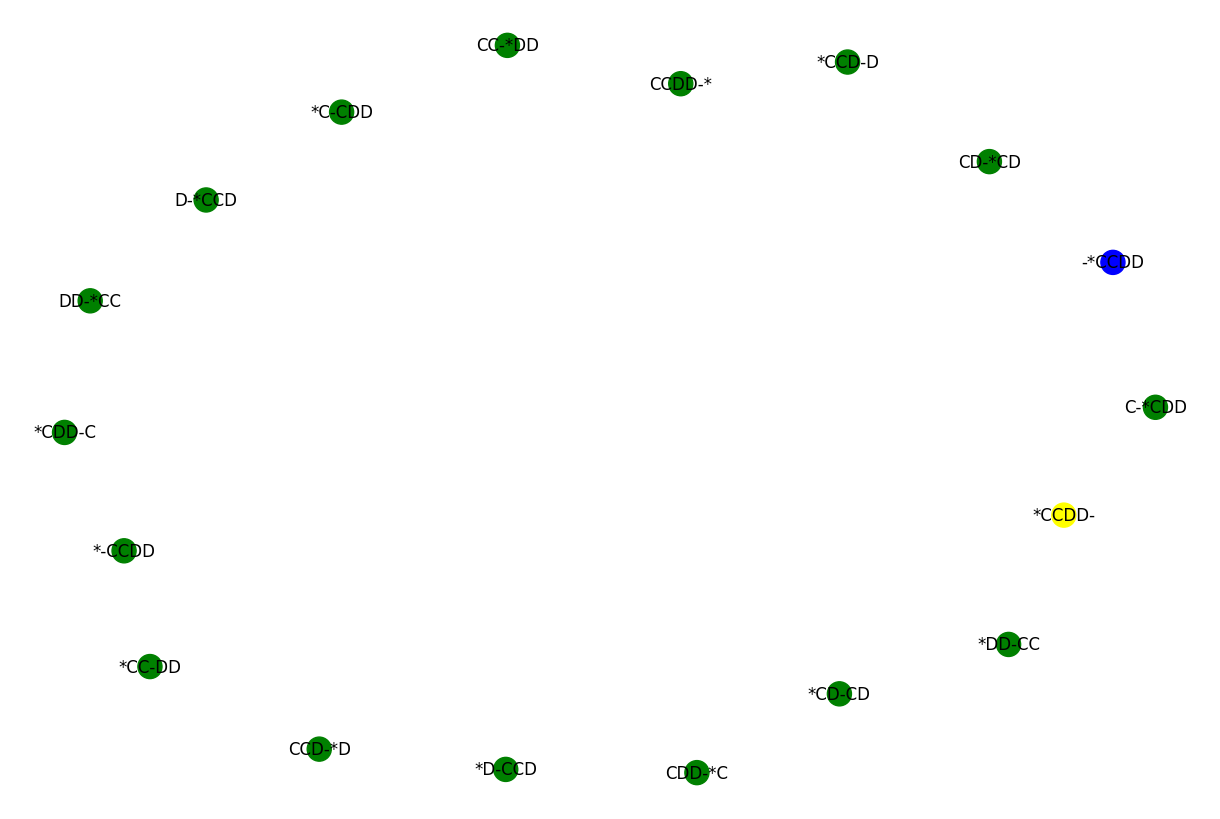

In [58]:
def node2sets(node): # string to pizzeria and pub multisets
    pizzeria, pub = node.split("-")
    return Multiset(pizzeria), Multiset(pub)


def sets2node(pizzeria, pub): # pizzeria and multisets to string
    return "".join(pizzeria) + "-" + "".join(pub)


SOURCE = "*" + "C" * (NUM_FRIENDS // 2) + "D" * (NUM_FRIENDS // 2) + "-"
DESTINATION = "-*" + "C" * (NUM_FRIENDS // 2) + "D" * (NUM_FRIENDS // 2)


sspace = nx.Graph()
for c, d, b in product(range(NUM_FRIENDS // 2 + 1), range(NUM_FRIENDS // 2 + 1), [True, False]):
    pizzeria = ("*" if b else "") + "C" * c + "D" * d
    pub = ("*" if not b else "") + "C" * (NUM_FRIENDS // 2 - c) + "D" * (NUM_FRIENDS // 2 - d)
    if pizzeria + "-" + pub == SOURCE:
      print('source')
      sspace.add_node(pizzeria + "-" + pub, color= 'yellow')
    elif pizzeria + "-" + pub == DESTINATION:
      print('destination')
      sspace.add_node(pizzeria + "-" + pub, color= 'blue')
    else: sspace.add_node(pizzeria + "-" + pub, color= 'green')


colors = [node[1]['color'] for node in sspace.nodes(data=True)]
plt.figure(figsize=(12, 8))
nx.draw(sspace, node_color=colors, with_labels= True, font_color='black')

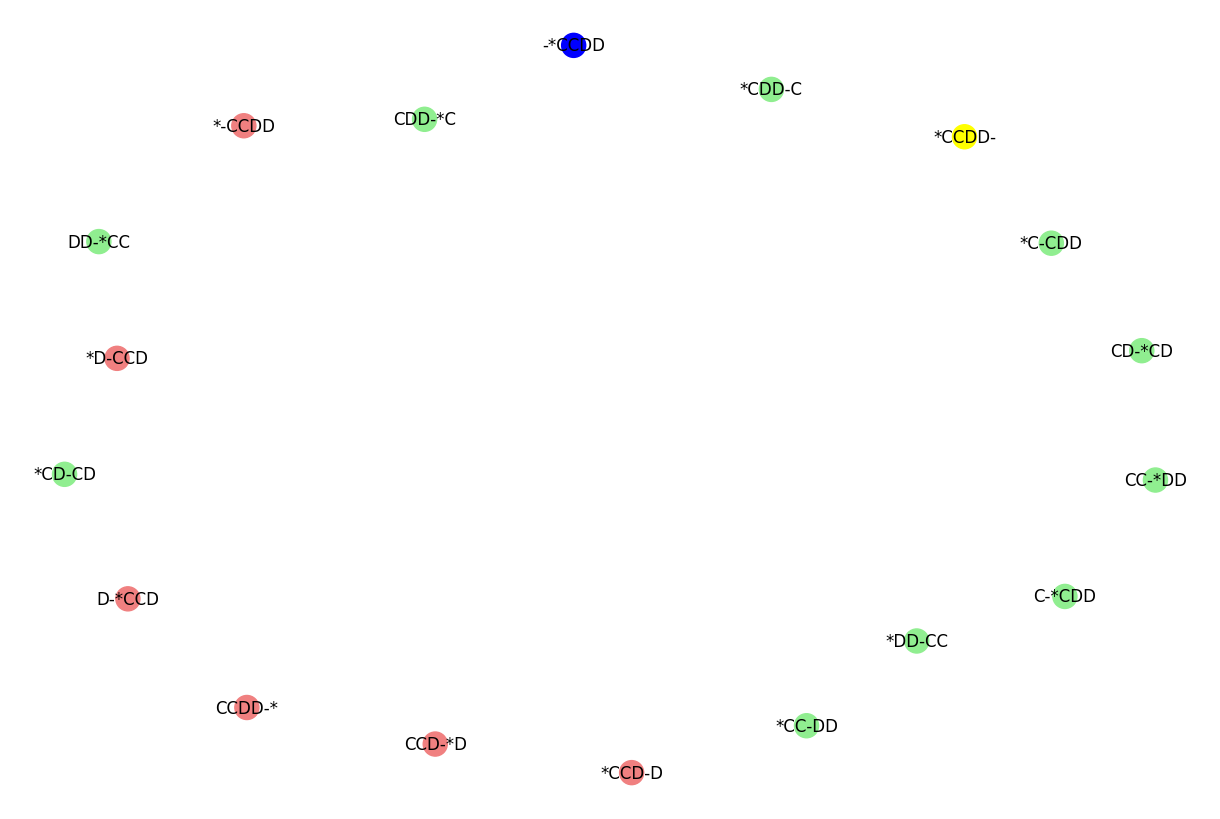

In [59]:
def valid_node(node): #take a node, split it to multisets and check if all is correct
    pizzeria, pub = node2sets(node)
    return valid_location(pizzeria) and valid_location(pub)


def valid_location(loc): # definition of correctness
    if loc.count("*") == 1 and len(loc) == 1: # tandem in a place with no people (did it drove itself there?)
        return False
    if 0 < loc.count("D") < loc.count("C"): # more C than D -> bored to death (if there is at least a D to be bored)
        return False
    return True


plt.figure(figsize=(12, 8))
nx.draw(
    sspace,
    with_labels=True,
    node_color=["yellow" if n == SOURCE else "blue" if n == DESTINATION else "lightgreen" if valid_node(n) else "lightcoral" for n in sspace],
)

<ipython-input-90-bae2f9bd9ecc>:23: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(sspace, pos=graphviz_layout(sspace), with_labels=True, node_color=node_color, edge_color=edge_colors)


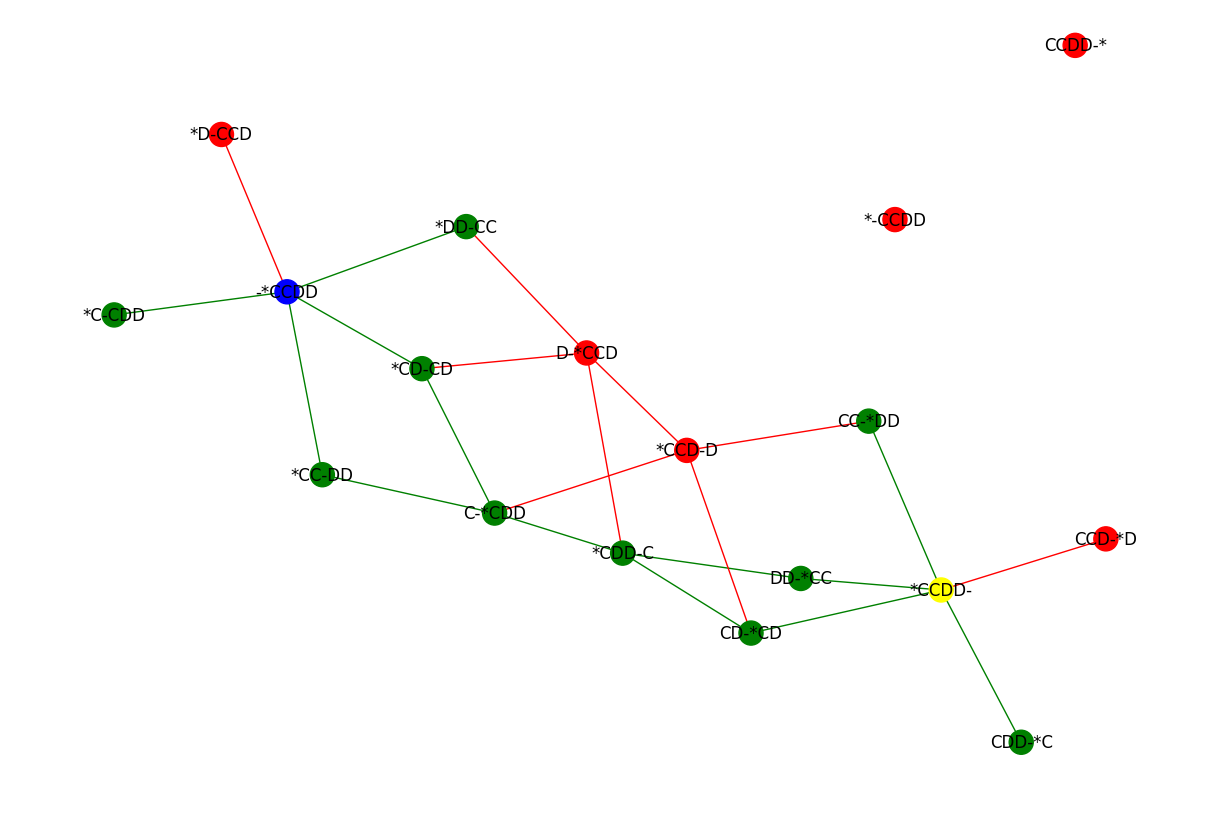

In [90]:
def bike(from_, to):
    possible = list()
    for b in ["*C", "*CC", "*D", "*DD", "*CD"]:
        bike = Multiset(b)
        if bike <= from_:
            possible.append(sets2node(from_ - bike, to + bike))
    return possible


valid_sspace = nx.Graph()

for node in sspace.nodes:
    if valid_node(node):
        valid_sspace.add_node(node)

for n1, n2 in [(a, b) for a in sspace.nodes for b in bike(*node2sets(a))]:
    if valid_node(n1) and valid_node(n2): sspace.add_edge(n1, n2, color= "green")
    else: sspace.add_edge(n1, n2, color= "red")

plt.figure(figsize=(12, 8))
node_color = ["yellow" if n == SOURCE else "blue" if n == DESTINATION else "green" if valid_node(n) else "red" for n in sspace]
edge_colors = [sspace[u][v]['color'] for u,v in sspace.edges()]
nx.draw(sspace, pos=graphviz_layout(sspace), with_labels=True, node_color=node_color, edge_color=edge_colors)

[('*CCDD-', 'CDD-*C'), ('*CCDD-', 'DD-*CC'), ('*CCDD-', 'CC-*DD'), ('*CCDD-', 'CD-*CD')]


<ipython-input-92-1108ac348d28>:23: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  nx.draw(valid_sspace, pos=graphviz_layout(valid_sspace), with_labels=True, node_color=node_color)


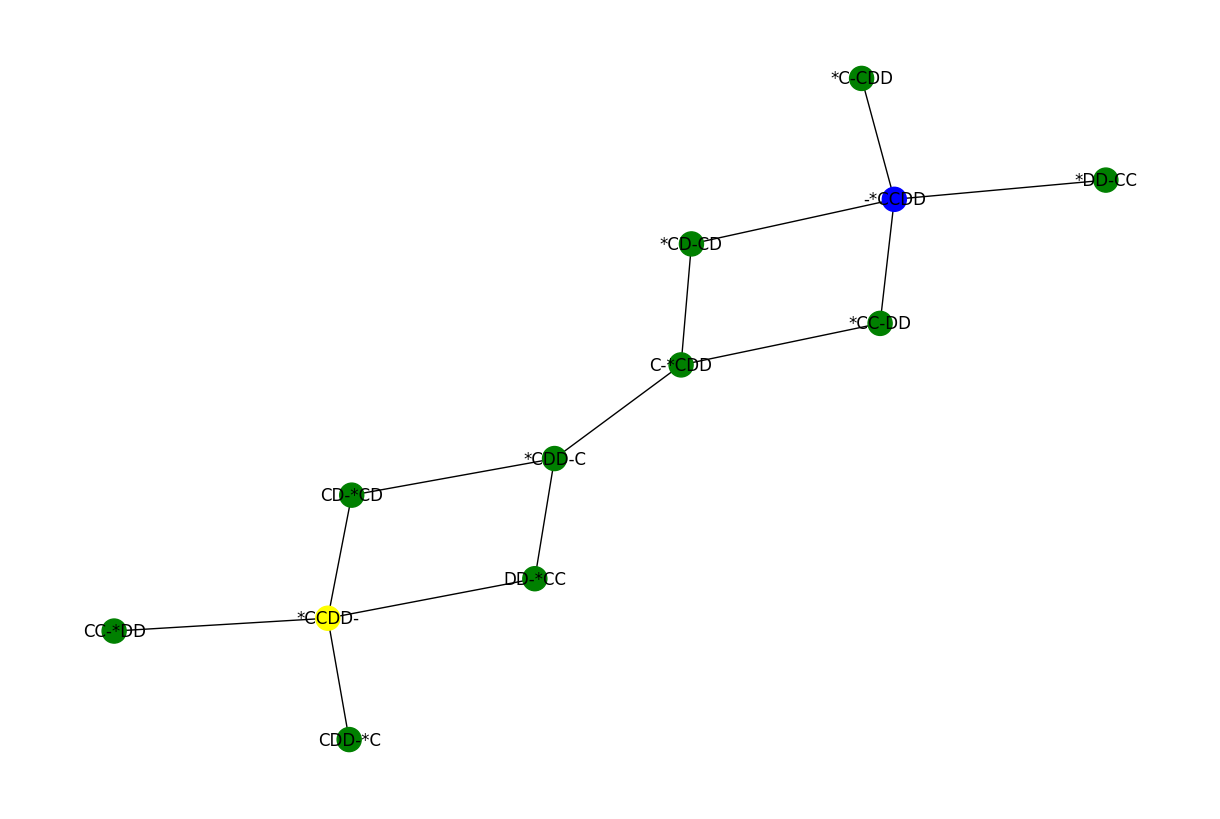

In [92]:
def bike(from_, to):
    possible = list()
    for b in ["*C", "*CC", "*D", "*DD", "*CD"]:
        bike = Multiset(b)
        if bike <= from_:
            possible.append(sets2node(from_ - bike, to + bike))
    return possible


valid_sspace = nx.Graph()

for node in sspace.nodes:
    if valid_node(node):
        valid_sspace.add_node(node)

print([(SOURCE, b) for b in bike(*node2sets(SOURCE)) if valid_node(b)])

for n1, n2 in [(a, b) for a in valid_sspace.nodes for b in bike(*node2sets(a)) if valid_node(b)]:
    valid_sspace.add_edge(n1, n2)

plt.figure(figsize=(12, 8))
node_color = ["yellow" if n == SOURCE else "blue" if n == DESTINATION else "green" for n in valid_sspace]
nx.draw(valid_sspace, pos=graphviz_layout(valid_sspace), with_labels=True, node_color=node_color)

In [93]:
nx.shortest_path(valid_sspace, SOURCE, DESTINATION)

['*CCDD-', 'DD-*CC', '*CDD-C', 'C-*CDD', '*CD-CD', '-*CCDD']